# Single Replica TIS

This notebook shows how to run single replica TIS move scheme. This assumes you can load engine, network, and initial sample from a previous calculation.

In [29]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from openpathsampling.visualize import PathTreeBuilder, PathTreeBuilder
from IPython.display import SVG, HTML

def ipynb_visualize(movevis):
    """Default settings to show a movevis in an ipynb."""
    view = movevis.renderer
    view.zoom = 1.5
    view.scale_y = 18
    view.scale_th = 20
    view.font_size = 0.4
    return view

Open the storage and load things from it.

In [3]:
old_store = paths.AnalysisStorage("mstis.nc")

In [4]:
network = old_store.networks[0]
engine = old_store.engines[0]
template = old_store.snapshots[0]

In [5]:
network.hist_args['max_lambda'] = { 'bin_width' : 0.02, 'bin_range' : (0.0, 0.5) }
network.hist_args['pathlength'] = { 'bin_width' : 5, 'bin_range' : (0, 150) }
rate = network.rate_matrix(old_store)

In [6]:
# this is the normal way you'd get this table
table = {}
for t in network.sampling_transitions:
    for ens, lambda_ens in zip(t.ensembles, [0.04, 0.09, 0.15]):
        table[ens] = t.tcp(lambda_ens)
for ens in network.special_ensembles['ms_outer'].keys():
    table[ens] = t.tcp(0.25)
    
# However, we usually have a short run in "mstis.nc"
# Here are results that I got from a 10k MC step run
desired_table = {
    "Out A 0" : 1.0,
    "Out A 1" : 0.173309694861,
    "Out A 2" : 0.0313583663237,
    "Out B 0" : 1.0,
    "Out B 1" : 0.160890328216,
    "Out B 2" : 0.051973864353,
    "Out C 0" : 1.0,
    "Out C 1" : 0.199477413032,
    "Out C 2" : 0.0510981189435,
    "[UnionEnsemble]" : 0.00340679708336
}
# now we'll fix `table` to `desired_table`
table = {}
my_ensembles = network.sampling_ensembles + network.special_ensembles['ms_outer'].keys()
for ens in my_ensembles:
    table[ens] = desired_table[ens.name]

In [7]:
bias = paths.BiasEnsembleTable(table)

In [8]:
print table

{<openpathsampling.ensemble.TISEnsemble object at 0x111490e10>: 1.0, <openpathsampling.ensemble.TISEnsemble object at 0x1114b0890>: 0.051973864353, <openpathsampling.ensemble.TISEnsemble object at 0x110fac6d0>: 1.0, <openpathsampling.ensemble.TISEnsemble object at 0x110ee87d0>: 0.0313583663237, <openpathsampling.ensemble.TISEnsemble object at 0x1114a8550>: 0.173309694861, <openpathsampling.ensemble.TISEnsemble object at 0x1114b0990>: 0.160890328216, <openpathsampling.ensemble.TISEnsemble object at 0x1114b0390>: 0.199477413032, <openpathsampling.ensemble.UnionEnsemble object at 0x1114b0d90>: 0.00340679708336, <openpathsampling.ensemble.TISEnsemble object at 0x110c481d0>: 0.0510981189435, <openpathsampling.ensemble.TISEnsemble object at 0x1114c1d50>: 1.0}


In [9]:
print bias

Here we actually set up the SRTIS move scheme for the given network. It only requires one line:

In [10]:
scheme = paths.SRTISScheme(network, bias)

Now we'll visualize the SRTIS move scheme.

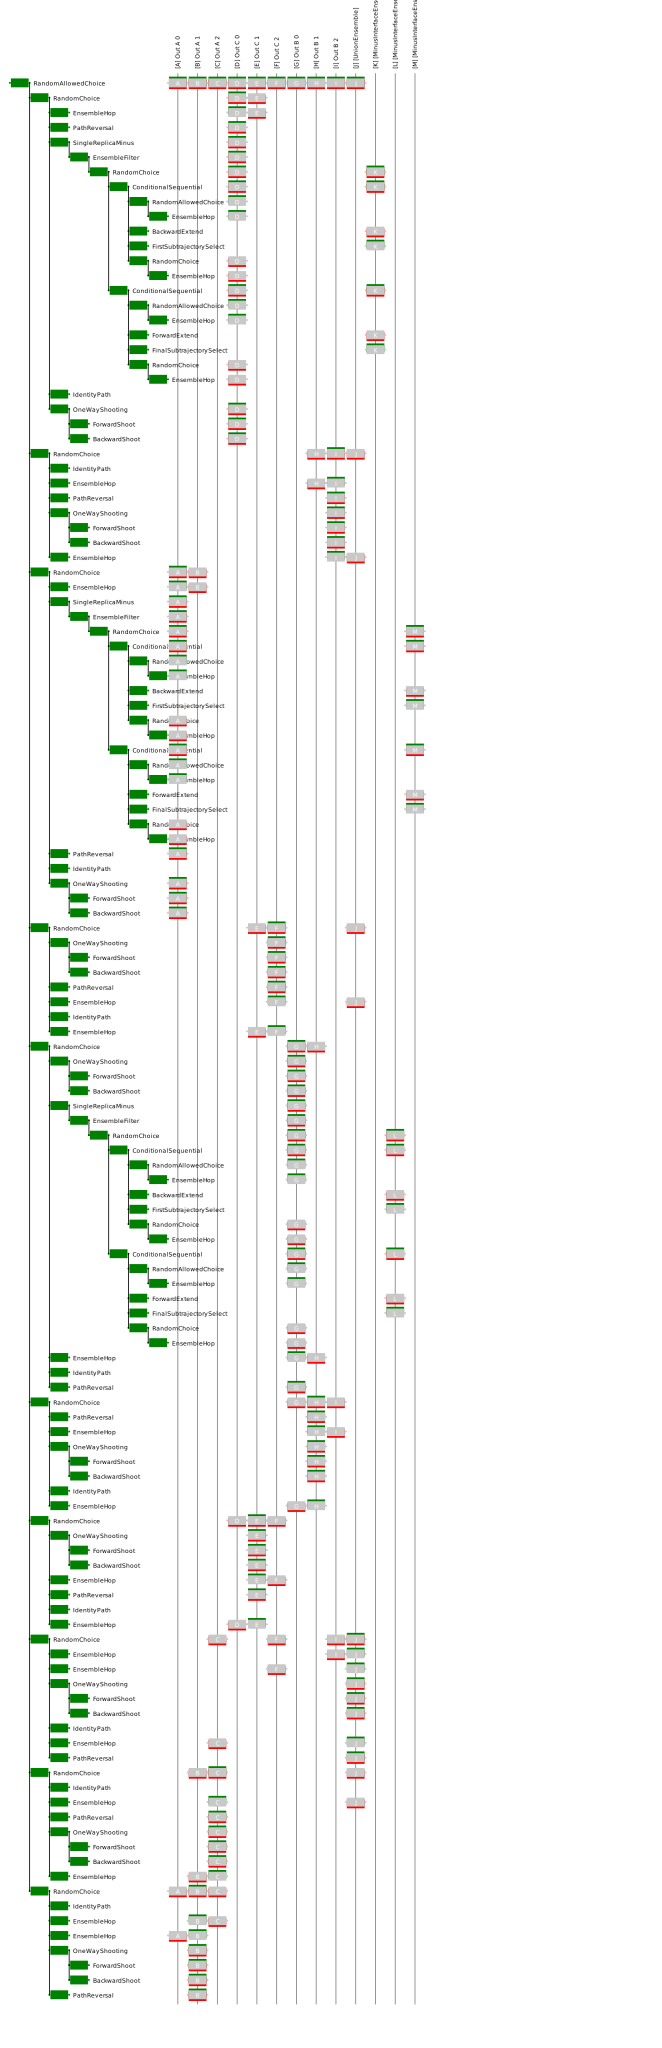

In [11]:
movevis = paths.visualize.MoveTreeBuilder()
movevis.mover(scheme.move_decision_tree(), network.all_ensembles)
SVG(ipynb_visualize(movevis).to_svg())

Next we need to set up an appropriate single-replica initial sample set. We'll take the last version of from one of the outer TIS ensembles.

In [12]:
final_samp0 = old_store.steps[len(old_store.steps)-1].active[network.sampling_ensembles[-1]]

In [13]:
sset = paths.SampleSet([final_samp0])

Finally, we set up the new storage file and the new simulation. 

In [14]:
storage = paths.Storage("srtis.nc", "w", template)

In [15]:
srtis = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    engine=engine,
    move_scheme=scheme
)

In [16]:
n_steps_to_run = int(scheme.n_steps_for_trials(
        mover=scheme.movers['minus'][0], 
        n_attempts=2
    ))
print n_steps_to_run

2460


In [17]:
# logging creates ops_output.log file with details of what the calculation is doing
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [18]:
srtis.run_until(1*n_steps_to_run)

Working on Monte Carlo cycle number 2460.

DONE! Completed 2460 Monte Carlo cycles.



In [19]:
storage.close()

From here, we'll be doing the analysis of the SRTIS run.

In [3]:
storage = paths.AnalysisStorage("srtis.nc")
scheme = storage.schemes[0]

In [4]:
scheme.move_summary(storage)

ms_outer_shooting ran 2.864% (expected 4.07%) of the cycles with acceptance 1013/1409 (71.89%)
repex ran 5.486% (expected 36.59%) of the cycles with acceptance 213/2699 (7.89%)
shooting ran 1.226% (expected 36.59%) of the cycles with acceptance 444/603 (73.63%)
minus ran 0.057% (expected 2.44%) of the cycles with acceptance 27/28 (96.43%)
pathreversal ran 1.955% (expected 20.33%) of the cycles with acceptance 919/962 (95.53%)


In [5]:
scheme.move_summary(storage, 'shooting')

OneWayShootingMover Out B 0 ran 0.065% (expected 4.07%) of the cycles with acceptance 24/32 (75.00%)
OneWayShootingMover Out B 2 ran 0.146% (expected 4.07%) of the cycles with acceptance 45/72 (62.50%)
OneWayShootingMover Out A 0 ran 0.154% (expected 4.07%) of the cycles with acceptance 64/76 (84.21%)
OneWayShootingMover Out C 2 ran 0.321% (expected 4.07%) of the cycles with acceptance 109/158 (68.99%)
OneWayShootingMover Out C 0 ran 0.071% (expected 4.07%) of the cycles with acceptance 30/35 (85.71%)
OneWayShootingMover Out B 1 ran 0.075% (expected 4.07%) of the cycles with acceptance 26/37 (70.27%)
OneWayShootingMover Out A 2 ran 0.154% (expected 4.07%) of the cycles with acceptance 56/76 (73.68%)
OneWayShootingMover Out A 1 ran 0.140% (expected 4.07%) of the cycles with acceptance 51/69 (73.91%)
OneWayShootingMover Out C 1 ran 0.098% (expected 4.07%) of the cycles with acceptance 39/48 (81.25%)


In [6]:
scheme.move_summary(storage, 'minus')

SingleReplicaMinus ran 0.014% (expected 0.81%) of the cycles with acceptance 7/7 (100.00%)
SingleReplicaMinus ran 0.026% (expected 0.81%) of the cycles with acceptance 13/13 (100.00%)
SingleReplicaMinus ran 0.016% (expected 0.81%) of the cycles with acceptance 7/8 (87.50%)


In [7]:
scheme.move_summary(storage, 'repex')

EnsembleHop [UnionEnsemble]->Out B 2 ran 1.433% (expected 2.03%) of the cycles with acceptance 21/705 (2.98%)
EnsembleHop Out C 2->[UnionEnsemble] ran 0.157% (expected 2.03%) of the cycles with acceptance 28/77 (36.36%)
EnsembleHop Out A 2->[UnionEnsemble] ran 0.071% (expected 2.03%) of the cycles with acceptance 16/35 (45.71%)
EnsembleHop Out A 0->Out A 1 ran 0.069% (expected 2.03%) of the cycles with acceptance 2/34 (5.88%)
EnsembleHop Out B 1->Out B 2 ran 0.045% (expected 2.03%) of the cycles with acceptance 9/22 (40.91%)
EnsembleHop Out B 2->Out B 1 ran 0.065% (expected 2.03%) of the cycles with acceptance 9/32 (28.12%)
EnsembleHop Out B 1->Out B 0 ran 0.041% (expected 2.03%) of the cycles with acceptance 3/20 (15.00%)
EnsembleHop Out A 2->Out A 1 ran 0.087% (expected 2.03%) of the cycles with acceptance 3/43 (6.98%)
EnsembleHop Out C 2->Out C 1 ran 0.152% (expected 2.03%) of the cycles with acceptance 18/75 (24.00%)
EnsembleHop Out C 0->Out C 1 ran 0.039% (expected 2.03%) of the c

In [10]:
replica = storage.samplesets[0].samples[0].replica
print len(paths.trace_ensembles_for_replica(replica, storage))

49201


In [50]:
srtis_ensembles = scheme.network.sampling_ensembles+scheme.network.special_ensembles['ms_outer'].keys()
srtis_ensemble_numbers = {e : srtis_ensembles.index(e) for e in srtis_ensembles}
# this next is just for pretty printing
srtis_numbers_ensemble = {srtis_ensemble_numbers[e] : e for e in srtis_ensemble_numbers}
for k in sorted(srtis_numbers_ensemble.keys()):
    print k, ":", srtis_numbers_ensemble[k].name

0 : Out C 0
1 : Out C 1
2 : Out C 2
3 : Out A 0
4 : Out A 1
5 : Out A 2
6 : Out B 0
7 : Out B 1
8 : Out B 2
9 : [UnionEnsemble]


In [35]:
ensemble_trace = paths.trace_ensembles_for_replica(replica, storage)

In [54]:
hist_numbers = [srtis_ensembles.index(e) for e in ensemble_trace]
bins = [i-0.5 for i in range(len(srtis_ensembles)+1)]

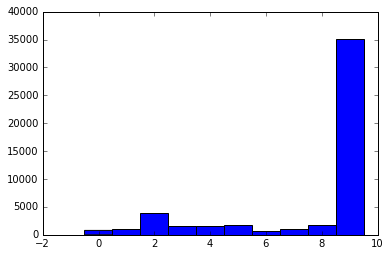

In [55]:
plt.hist(hist_numbers, bins=bins);

In [96]:
import pandas as pd
hist = paths.analysis.Histogram(bin_width=1.0, bin_range=[-0.5,9.5])
colnames = [srtis_numbers_ensemble[i].name for i in range(len(srtis_ensembles))]
df = pd.DataFrame(columns=colnames)

In [97]:
for i in range(len(hist_numbers)):
    hist.add_data_to_histogram([hist_numbers[i]])
    if i % 100 == 0:
        local_df = pd.DataFrame([hist.normalized().values()], columns=colnames)
        df = df.append(local_df)

In [98]:
df

,Out C 0,Out C 1,Out C 2,Out A 0,Out A 1,Out A 2,Out B 0,Out B 1,Out B 2,[UnionEnsemble]
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.875156,0.000000,0.000000,0.000000,0.124844
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.778024,0.000000,0.000000,0.000000,0.221976
